In [1]:
# 1. create data reader
# 2. BioTac - combine original with calibrated for timings

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [3]:
data_dir = '../data/processed_25_02_2020/'
fname = 'trial4'

### BioTac

In [4]:
#bdata_calibrated = pickle.load(open(data_dir + fname +'_calibrated.pkl', 'rb'))
#bdata_original = pickle.load(open(data_dir + fname +'_original.pkl', 'rb'))

In [5]:
class BIO():
    def __init__(self, data_dir, fname):
        
        # define variables
        self.data_dir = data_dir
        self.fname = fname
        
        self.pac_names = ['received_t', 't', 'pac']
        self.pac = None
        
        self.pdc_names = ['received_t', 't', 'pdc']
        self.pdc = None
        
        
        # parse pkl data
        self.read_data()
        self.parse()
        
    def read_data(self):
        self.bdata_calibrated = pickle.load(open(self.data_dir + self.fname +'_calibrated.pkl', 'rb'))
        self.bdata_original = pickle.load(open(self.data_dir + self.fname +'_original.pkl', 'rb'))
        
    def parse(self):
        pac = []
        pdc = []
        count = 1
        for (row_cal, row_original) in zip(self.bdata_calibrated, self.bdata_original):
            sampled_time = row_original[1]
            frame_start = row_original[2]
            
            # pac
            pac_count = 1
            for _pac, _pac_t in zip(row_cal[12], row_original[7]):
                
                # correct_pac
                _sample_point_offset = _pac_t*1e-9
                PAC_PERIOD = 0.000455 # 2.2 kHz
                if _pac_t >= 0.1:
                    pac.append([sampled_time, frame_start+PAC_PERIOD*pac_count, _pac])
                else:
                    pac.append([sampled_time, frame_start+_pac_t*1e-9, _pac])
                pac_count += 1
                
            #pdc
            _pdc_offset = row_original[6]*1e-9
            if _pdc_offset >= 0.5:
                pdc.append([sampled_time, frame_start+0.008636678*count, row_original[11]])
            else:
                pdc.append([sampled_time, frame_start+_pdc_offset, row_original[11]])
            
            count+=1
            
        self.pac = pd.DataFrame(columns=self.pac_names, data=pac)
        self.pdc = pd.DataFrame(columns=self.pdc_names, data=pdc)

In [6]:
bio = BIO(data_dir, fname)

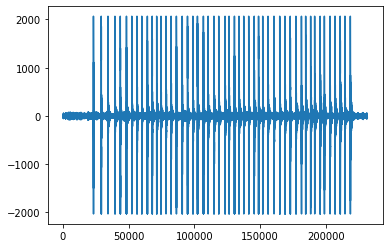

In [7]:
# find peaks
plt.plot( bio.pac.pac )
plt.show()

In [8]:
peaks, _ = find_peaks(bio.pac.pac, height=[1800, 2200], distance=130*22)

In [9]:
len(peaks)

50

/home/tasbolat/tas_python_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/tasbolat/tas_python_env/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/tasbolat/tas_python_env/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


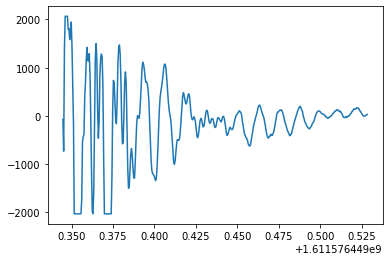

In [10]:
# find peaks
plt.plot( bio.pac.t[peaks[0]-5:peaks[0]+400], bio.pac.pac[peaks[0]-5:peaks[0]+400] )
plt.show()

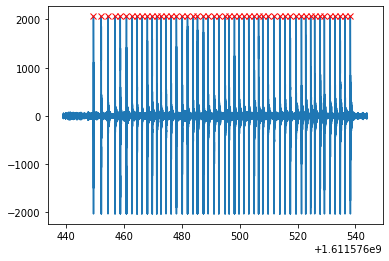

In [11]:
# find peaks
plt.plot( bio.pac.t, bio.pac.pac )
plt.plot( bio.pac.t[peaks], bio.pac.pac[peaks], 'rx')

plt.show()

In [12]:
# get times
contact_times = bio.pac.t[peaks]-5*1/2.2e3 # substact 5 data points (manual)

### optitrack data

In [13]:
opt = pickle.load(open(data_dir + fname +'_optitrack_rb.pkl', 'rb'))
TABLE_ID = 1
TABLE_MARKER_SIZE = 7

BIO_ID = 2
BIO_MARKER_SIZE = 4

TOOL_ID = 3
TOOL_MARKER_SIZE = 4

In [14]:
# opt[0]

In [15]:
def parse_optitrack(_id, _marker_number):

    col_names = ['t', 'p_x', 'p_y', 'p_z', 'q_w', 'q_x', 'q_y', 'q_z']

    marker_sizes = _marker_number
    for i in range(marker_sizes):
        col_names.append( 'marker_x_' + str(i))
        col_names.append( 'marker_y_' + str(i))
        col_names.append( 'marker_z_' + str(i))

    all_table_data = []
    for row in opt:
        for rb in row[2:]:
            if rb[0] == _id:
                table_data = []
                table_data.append(row[1])
                for i in range(7):
                    table_data.append(rb[i+1])
                for marker in rb[8:]:
                    for j in range(3):
                        table_data.append(marker[j])
                all_table_data.append(table_data)
    df = pd.DataFrame(data=all_table_data, columns=col_names)
    return df

In [16]:
table_df = parse_optitrack(TABLE_ID, TABLE_MARKER_SIZE)
tool_df = parse_optitrack(TOOL_ID, TOOL_MARKER_SIZE)
bio_df = parse_optitrack(BIO_ID, BIO_MARKER_SIZE)

In [17]:
bio_df

,t,p_x,p_y,p_z,q_w,q_x,q_y,q_z,marker_x_0,marker_y_0,marker_z_0,marker_x_1,marker_y_1,marker_z_1,marker_x_2,marker_y_2,marker_z_2,marker_x_3,marker_y_3,marker_z_3
0,1.611576e+09,0.407238,0.029785,-0.028989,0.939774,-0.020276,0.057523,-0.336312,0.426949,0.042828,-0.110941,0.387847,0.078501,-0.081029,0.429519,0.095133,-0.085568,0.434964,0.072957,-0.104752
1,1.611576e+09,0.406996,0.029828,-0.029050,0.939685,-0.019838,0.056135,-0.336820,0.426959,0.042842,-0.110945,0.387806,0.078554,-0.081156,0.429507,0.095136,-0.085578,0.434985,0.072959,-0.104739
2,1.611576e+09,0.407104,0.029800,-0.029046,0.939767,-0.019954,0.056669,-0.336493,0.426963,0.042841,-0.110952,0.387825,0.078523,-0.081122,0.429506,0.095118,-0.085589,0.434993,0.072980,-0.104762
3,1.611576e+09,0.407260,0.029780,-0.028988,0.939845,-0.020336,0.057495,-0.336112,0.426968,0.042828,-0.110940,0.387849,0.078482,-0.081034,0.429514,0.095129,-0.085574,0.434968,0.072953,-0.104757
4,1.611576e+09,0.407010,0.029807,-0.029055,0.939684,-0.019813,0.056244,-0.336804,0.426954,0.042832,-0.110949,0.387808,0.078540,-0.081151,0.429507,0.095119,-0.085579,0.434988,0.072953,-0.104747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12632,1.611577e+09,0.407103,0.029832,-0.028940,0.940082,-0.019877,0.056722,-0.335609,0.426956,0.043015,-0.110829,0.387731,0.078534,-0.081001,0.429382,0.095181,-0.085481,0.434877,0.073018,-0.104642
12633,1.611577e+09,0.406932,0.029848,-0.028984,0.940049,-0.019447,0.055725,-0.335893,0.426969,0.043033,-0.110824,0.387700,0.078567,-0.081081,0.429372,0.095166,-0.085485,0.434894,0.073047,-0.104608
12634,1.611577e+09,0.407171,0.029804,-0.028937,0.940170,-0.019913,0.057031,-0.335308,0.426966,0.043023,-0.110829,0.387738,0.078504,-0.080977,0.429373,0.095166,-0.085483,0.434876,0.073022,-0.104651
12635,1.611577e+09,0.407149,0.029789,-0.028938,0.940192,-0.019760,0.056966,-0.335266,0.426963,0.043024,-0.110827,0.387723,0.078500,-0.080970,0.429365,0.095153,-0.085478,0.434860,0.073048,-0.104614


In [18]:
# table parse
table_df.filter(like='_3' ).mean()

marker_x_3   -0.050745
marker_y_3    0.009212
marker_z_3    0.499785
dtype: float64

In [19]:
%matplotlib notebook

<IPython.core.display.Javascript object>


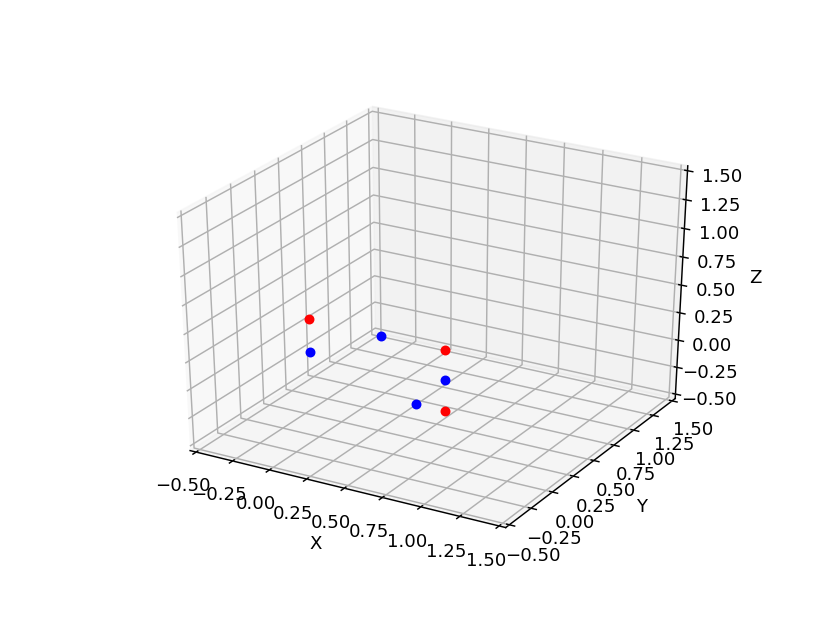

In [20]:
BL, BR, TR = 3, 2, 6 # marker ids
marker_ids = [BL, BR, TR]

from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
# mapping from optitrack to world: x,y,z - > x, z, -y
ax = fig.add_subplot(111, projection='3d')
for i in range(TABLE_MARKER_SIZE):
    mm = table_df.filter(like=str(i) ).mean()
    if i in marker_ids:
        ax.scatter(mm[0], mm[1], mm[2], c='r')
    else:
        ax.scatter(mm[0], mm[1], mm[2], c='b')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5])
ax.set_zlim([-0.5, 1.5])

plt.show()

In [21]:
# find nearest time
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [22]:
labels_x_z = []
raw_poses = []
for tapped_time in contact_times:
    idx = table_df.t == find_nearest( table_df.t.values, tapped_time )
    
    # get x,z coordinates of corners
    TL_x = table_df[idx].p_x.values[0]
    TL_z = table_df[idx].p_z.values[0]
    
    sp = table_df[idx].filter(like='_' + str(BL) )
    BL_x = sp.filter(like='x').values[0]
    BL_z = sp.filter(like='z').values[0]
    
    sp = table_df[idx].filter(like='_' + str(BR) )
    BR_x = sp.filter(like='x').values[0]
    BR_z = sp.filter(like='z').values[0]
    
    sp = table_df[idx].filter(like='_' + str(TR) )
    TR_x = sp.filter(like='x').values[0]
    TR_z = sp.filter(like='z').values[0]
    
    # get tool value
    idx = tool_df.t == find_nearest(  tool_df.t.values, tapped_time )
    raw_x = tool_df[idx].p_x.values[0]
    raw_z = tool_df[idx].p_z.values[0]
    
    # get biotac value
    # TODO
    
    # normalize accross table
    x = raw_x - TL_x
    z = raw_z - TL_z
    raw_poses.append([raw_x,raw_z])
    labels_x_z.append([x,  z])

In [23]:
raw_poses = np.array(raw_poses)

<IPython.core.display.Javascript object>


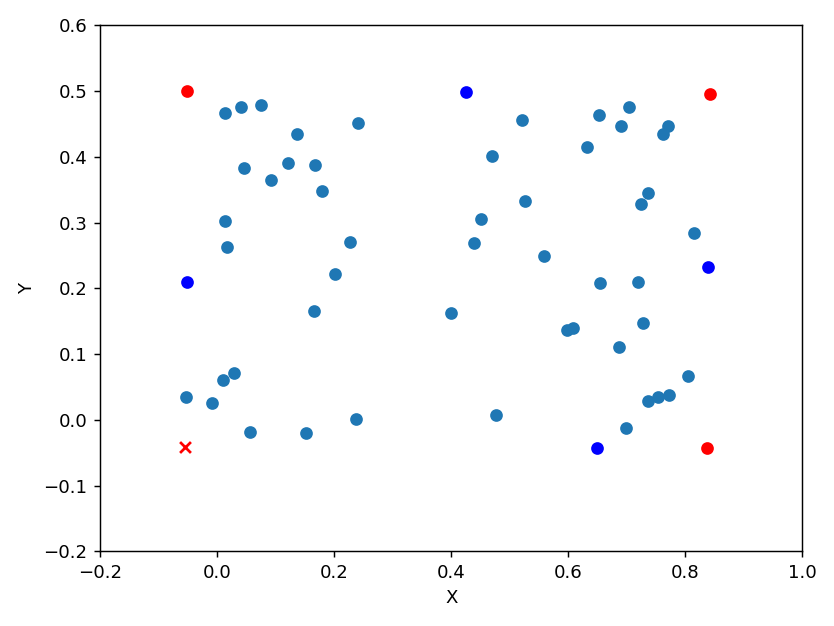

In [24]:


fig, ax = plt.subplots()
for i in range(TABLE_MARKER_SIZE):
    mm = table_df.filter(like=str(i) ).mean()
    if i in marker_ids:
        ax.scatter(mm[0], mm[2], c='r')
    else:
        ax.scatter(mm[0], mm[2], c='b')
        
mm = table_df.filter(like='p_' ).mean()
ax.scatter(mm[0], mm[2], c='r', marker='x')

ax.scatter(raw_poses[:,0], raw_poses[:,1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Z')
ax.set_xlim([-0.2, 1.0])
ax.set_ylim([-0.2, 0.6])
#ax.set_zlim([-0.5, 1.5])
plt.tight_layout(True)
plt.savefig(data_dir + fname +'.png')
plt.show()

In [25]:
import tsfel
fs = 2.2e3

### Feature extraction
features_name = ["max_frequency", "max_power_spectrum", "power_bandwidth", "fft_mean_coeff", "spectral_spread", "fundamental_frequency", 'x','z']

In [26]:
features = []
for i, peak in enumerate( peaks ):
    signal = np.array( bio.pac.pac[-5+peak:peak+1095] )
    max_frequency = tsfel.feature_extraction.max_frequency(signal, fs)
    max_power_spectrum = tsfel.feature_extraction.max_power_spectrum(signal, fs)
    power_bandwidth = tsfel.feature_extraction.power_bandwidth(signal, fs)
    fft_mean_coeff = max( tsfel.feature_extraction.fft_mean_coeff(signal, fs, nfreq=1100) )
    spectral_spread = tsfel.feature_extraction.spectral_spread(signal, fs)
    fundamental_frequency = tsfel.feature_extraction.fundamental_frequency(signal, fs)
    features.append([max_frequency, max_frequency, power_bandwidth, fft_mean_coeff, spectral_spread, fundamental_frequency, labels_x_z[i][0], labels_x_z[i][1]])

In [27]:
features_df = pd.DataFrame(columns=features_name, data=features)

In [28]:
#features_df

In [29]:
features_df.to_csv(data_dir+ fname+ '_features.csv', index=False)